
命令行下载配置环境

In [ ]:
!pip3 install mtcnn
!pip3 install opencv-contrib-python

加载云端硬盘

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


加载 mtcnn, opencv

In [ ]:
from mtcnn.mtcnn import MTCNN
import cv2

mtcnn 人脸检测

In [ ]:
def face_detect(img):
  # mtcnn 人脸检测器
  face_detector = MTCNN()

  # 找到图中所有人脸位置
  face_locations = face_detector.detect_faces(img)
  print("图中检测到 {} 张人脸".format(len(face_locations)))

  # 返回人脸位置
  return face_locations

转化为正方形人脸图像

In [ ]:
def face_square(img, bounding):
  # 人脸范围尺寸
  [x, y, width, height] = bounding

  # 图片尺寸范围
  height_pic, width_pic, channel = img.shape

  # 判断人脸是否溢出画面
  # new_x = 0 if x <= 0 else x
  # new_y = 0 if y <= 0 else y
  # new_width = width_pic - new_x if x + width > width_pic else x + width - new_x
  # new_height = height_pic - new_y if y + height > height_pic else y + height - new_y

  # 替换新尺寸
  # x, y, width, height = new_x, new_y, new_width, new_height

  # 宽度和高度取较大值
  l = width if width > height else height
  
  # 宽度和高度中较短边对称拉伸扩展至较长边的长度
  x = x + 0.5 * width - 0.5 * l
  y = y + 0.5 * height - 0.5 * l

  # 为了防止对齐后出现空白区域, 矩形边长加倍
  x = x - 0.5 * l
  y = y - 0.5 * l
  l = l * 2

  # 判断正方形区域是否溢出画面
  # x = 0 if x <= 0 else x
  # x = width_pic - l if x + l > width_pic else x
  # y = 0 if y <= 0 else y
  # y = height_pic - l if y + l > height_pic else y

  # 返回: [左上角横坐标, 左上角纵坐标, 正方形边长, 正方形边长]
  return [x, y, l, l]

加载 math, numpy

In [ ]:
import math
import numpy as np

图像水平对齐

In [ ]:
def face_warp(img, keypoints):
  # 左右眼位置
  x_r, y_r = keypoints['right_eye']
  x_l, y_l = keypoints['left_eye']

  # 左右眼相对位置
  x = x_r - x_l
  y = y_r - y_l

  # 显示相对位置
  # print("左右眼相对位置: ({},{})".format(x, y))

  # 计算倾斜角度弧度制
  if x == 0:
    angle = 0
  else:
    angle = math.atan(y / x) * 180 / math.pi

  # 中心位置
  height_pic, width_pic, channel = img.shape
  center = (width_pic//2, height_pic//2)

  # 旋转矩阵
  RotationMatrix = cv2.getRotationMatrix2D(center, angle, 1)

  # 仿射函数
  img_warp = cv2.warpAffine(img, RotationMatrix, (width_pic, height_pic)) 

  # 返回对齐的图片
  return img_warp

图片恢复一半大小并转为 160 * 160 尺寸

In [ ]:
def face_resize(img):
  # 图片尺寸
  height_pic, width_pic, channel = img.shape

  # 一半大小
  half_img = img[int(height_pic // 4):int(3 * height_pic // 4), int(width_pic // 4):int(3 * width_pic // 4)]

  # 尺寸变换
  resize_img = cv2.resize(half_img, (160, 160))

  # 返回图片
  return resize_img

高斯归一化预处理

In [ ]:
def pre_process(x):
  # 维数判定
  if x.ndim == 4:
    axis = (1, 2, 3)
    size = x[0].size
  elif x.ndim == 3:
    axis = (0, 1, 2)
    size = x.size
  else:
    raise ValueError('维数只能为3或4')

  mean = np.mean(x, axis=axis, keepdims=True)
  std = np.std(x, axis=axis, keepdims=True)
  std_adj = np.maximum(std, 1.0 / np.sqrt(size))
  y = (x - mean) / std_adj
  return y

l2 标准化

In [ ]:
def l2_normalize(x, axis=-1, epsilon=1e-10):
  output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
  return output

计算 128 维特征向量

In [ ]:
def calc_128_vec(facenet_model, img):
  # 高斯归一化预处理
  face_img = pre_process(img)
  
  # 模型预测
  pre = facenet_model.predict(face_img)
  
  # l2 标准化
  pre = l2_normalize(np.concatenate(pre))
  
  # 转为 128 维向量
  pre = np.reshape(pre, [128])

  # 返回向量  
  return pre

加载 plt 显示图像

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt

获取并显示图中人脸位置

In [ ]:
def face_show(img, bounding, keypoints):
  # 转换为正方形
  [x, y, width, height] = face_square(img, bounding)

  # 正方形人脸位置
  print("正方形人脸位置: x: {}, y: {}, width: {}, height: {}".format(x, y, width, height))

  # 图片截取
  img_face = img[int(y):int(y + height), int(x):int(x + width)]

  # 显示截取后图片
  plt.imshow(img_face)
  plt.show()

  # 水平对齐
  img_face = face_warp(img_face, keypoints)

  # 显示对齐后图片
  plt.imshow(img_face)
  plt.show()

  # 图片大小转为 160 * 160
  img_face = face_resize(img_face)

  # 显示尺寸变换后图片
  plt.imshow(img_face)
  plt.show()

  # 返回截取后图片
  return img_face

计算人脸特征向量距离

In [ ]:
def face_distance(face_encodings, face_to_compare):
  # 若数据库中无特征向量, 直接返回
  if len(face_encodings) == 0:
    return np.empty((0))

  # 按行计算两者差值, 求多个行向量的范数
  return np.linalg.norm(face_encodings - face_to_compare, axis=1)

比较人脸特征向量并根据阈值筛选出最可能的面部识别结果

In [ ]:
def compare_faces(known_face_encodings, known_face_names, face_encoding_to_check, tolerance=0.9):
  # 面部特征距离
  dis = face_distance(known_face_encodings, face_encoding_to_check) 
  print("distance:", dis)

  # 返回距离小于阈值的面部特征列表
  face_list = list(dis <= tolerance)
  print("result:", face_list)

  # 若无一个匹配成功, 则该人未出现在数据库中
  if True not in face_list:
    # 返回该人名称未知
    return "Unknown"

  # 投票字典
  vote = {}

  # 进行投票统计
  for i in range(len(face_list)):
    # 若低于阈值, 则该标签投票数加一
    if face_list[i] == True:
      # 若该标签不在字典中
      if known_face_names[i] not in vote:
        # 添加该标签
        vote[known_face_names[i]] = 1
      # 若该标签在字典中
      else:
        # 该标签数目加一
        vote[known_face_names[i]] = vote[known_face_names[i]] + 1

  # 获取票数最高的标签
  vote_name = max(vote, key=vote.get)
  
  # 返回判定结果
  return vote_name

加载 imageio, keras.models, os


In [ ]:
import imageio
from keras.models import load_model
import os

数据库图片初始化(对数据库中的人脸建立 128 维特征集, 后续才可以由实验图片进行对照)

In [ ]:
class face_dataset():
  def __init__(self):
    # 初始化数据库图像
    print("数据库图像初始化开始")

    # 加载模型
    self.facenet_model = load_model("/content/drive/MyDrive/facenet_model/facenet_keras.h5")
    
    # 模型输入输出类型
    # print(facenet_model.inputs)
    # print(facenet_model.outputs)

    # 打开数据集
    face_list = os.listdir("/content/drive/MyDrive/facenet_dataset")

    # 已标签过的人脸 128 维特征
    self.known_face_encodings = []

    # 已标签过的人脸名称
    self.known_face_names = []

    # 遍历数据库
    for face in face_list:
      # 运行错误文件夹下会生成隐藏文件 .ipynb_checkpoints
      # 为防止对图片读取进行干扰, 此处做后缀判断
      if face.split(".")[1] != 'jpg':
        continue

      # 名称分割  
      name = face.split("_")[0]

      # 图片名称
      img = imageio.imread("/content/drive/MyDrive/facenet_dataset/" + face)

      # 考虑到各种错综复杂的边界问题, 这里选择将画面边界延伸, 延伸部分均以白色代替
      img = cv2.copyMakeBorder(img, 1000, 1000, 1000, 1000, cv2.BORDER_CONSTANT, value=[255, 255, 255])
     
      # 人脸检测
      face_locations = face_detect(img)
      
      # 数据库每张图中仅一张人脸, 故可以直接读取
      face_location = face_locations[0]

      # 人脸位置数据显示
      print(face_location)
      
      # 获取并显示人脸
      img_face = face_show(img, face_location['box'], face_location['keypoints'])

      # 维度扩展 ()
      img_face = np.expand_dims(img_face, 0)

      # 利用 facenet_model 计算 128 维特征向量
      face_encoding = calc_128_vec(self.facenet_model, img_face)

      # 添加到已标签过的人脸 128 维特征
      self.known_face_encodings.append(face_encoding)
      
      # 添加到已标签过的人脸名称
      self.known_face_names.append(name)

      # 已完成数据库部分数据读取
      print("已读取图片: {}".format(face))
    
    # 数据库图像初始化结束
    print("数据库图像初始化结束")

    # 显示数据库标签集和数据库特征集
    # print("数据库特征向量:", self.known_face_encodings)
    # print("数据库人物名称:", self.known_face_names)

主函数

数据库图像初始化开始
图中检测到 1 张人脸
{'box': [1229, 1241, 183, 256], 'confidence': 0.9999938011169434, 'keypoints': {'left_eye': (1285, 1341), 'right_eye': (1367, 1341), 'nose': (1332, 1387), 'mouth_left': (1295, 1431), 'mouth_right': (1366, 1428)}}
正方形人脸位置: x: 1064.5, y: 1113.0, width: 512, height: 512


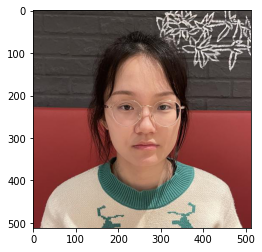

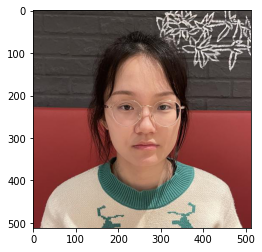

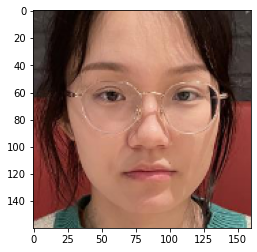

已读取图片: lhy_1.jpg
图中检测到 1 张人脸
{'box': [1163, 1116, 130, 176], 'confidence': 0.9999972581863403, 'keypoints': {'left_eye': (1205, 1181), 'right_eye': (1261, 1186), 'nose': (1231, 1218), 'mouth_left': (1204, 1247), 'mouth_right': (1249, 1252)}}
正方形人脸位置: x: 1052.0, y: 1028.0, width: 352, height: 352


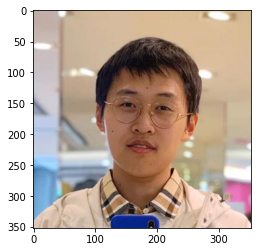

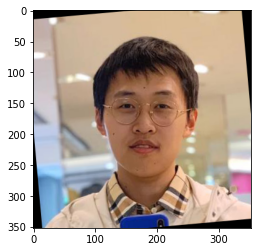

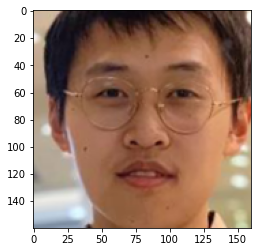

已读取图片: wjz_1.jpg
图中检测到 1 张人脸
{'box': [1258, 1187, 141, 188], 'confidence': 0.999232292175293, 'keypoints': {'left_eye': (1290, 1260), 'right_eye': (1357, 1265), 'nose': (1316, 1299), 'mouth_left': (1293, 1332), 'mouth_right': (1342, 1336)}}
正方形人脸位置: x: 1140.5, y: 1093.0, width: 376, height: 376


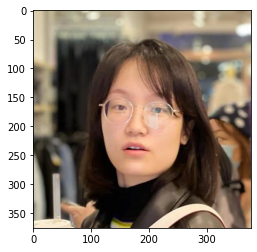

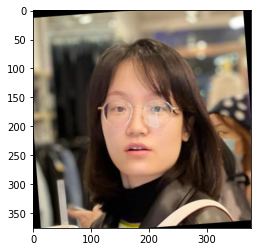

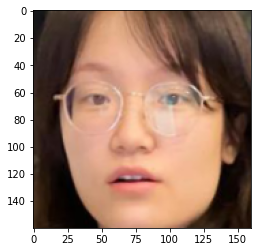

已读取图片: lhy_2.jpg
图中检测到 1 张人脸
{'box': [1230, 1267, 233, 298], 'confidence': 1.0, 'keypoints': {'left_eye': (1293, 1381), 'right_eye': (1396, 1373), 'nose': (1346, 1434), 'mouth_left': (1310, 1497), 'mouth_right': (1389, 1494)}}
正方形人脸位置: x: 1048.5, y: 1118.0, width: 596, height: 596


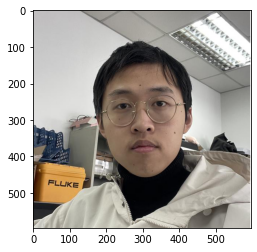

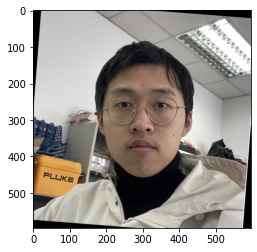

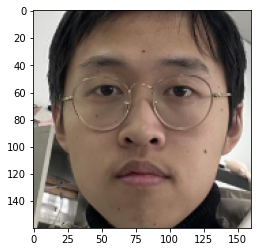

已读取图片: wjz_2.jpg
图中检测到 1 张人脸
{'box': [1147, 1183, 102, 135], 'confidence': 0.9999057054519653, 'keypoints': {'left_eye': (1185, 1237), 'right_eye': (1231, 1237), 'nose': (1213, 1263), 'mouth_left': (1189, 1288), 'mouth_right': (1224, 1287)}}
正方形人脸位置: x: 1063.0, y: 1115.5, width: 270, height: 270


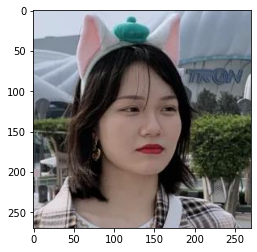

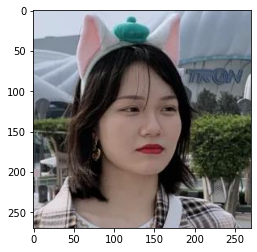

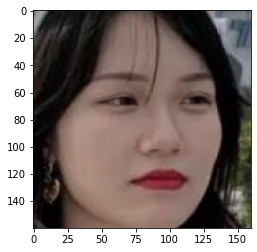

已读取图片: lhy_7.jpg
图中检测到 1 张人脸
{'box': [1142, 1100, 91, 115], 'confidence': 0.9998410940170288, 'keypoints': {'left_eye': (1164, 1148), 'right_eye': (1205, 1145), 'nose': (1185, 1170), 'mouth_left': (1170, 1189), 'mouth_right': (1207, 1185)}}
正方形人脸位置: x: 1072.5, y: 1042.5, width: 230, height: 230


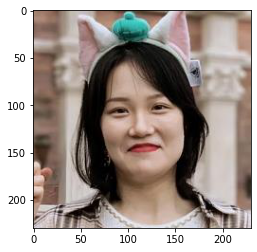

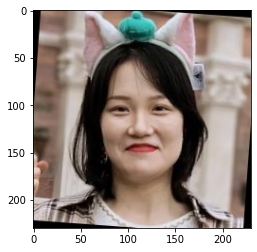

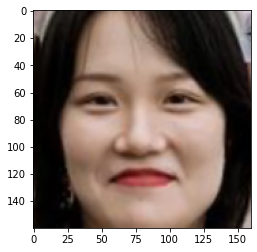

已读取图片: lhy_8.jpg
图中检测到 1 张人脸
{'box': [1167, 1157, 110, 141], 'confidence': 0.9999817609786987, 'keypoints': {'left_eye': (1205, 1205), 'right_eye': (1252, 1224), 'nose': (1222, 1243), 'mouth_left': (1190, 1252), 'mouth_right': (1231, 1270)}}
正方形人脸位置: x: 1081.0, y: 1086.5, width: 282, height: 282


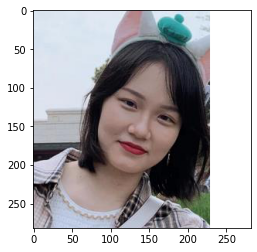

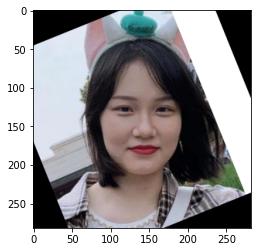

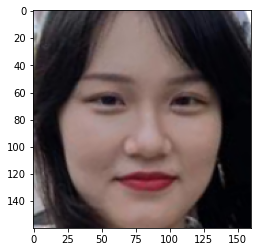

已读取图片: lhy_6.jpg
图中检测到 1 张人脸
{'box': [1524, 1503, 1232, 1654], 'confidence': 0.9999918937683105, 'keypoints': {'left_eye': (1874, 2154), 'right_eye': (2427, 2150), 'nose': (2147, 2497), 'mouth_left': (1936, 2806), 'mouth_right': (2347, 2815)}}
正方形人脸位置: x: 486.0, y: 676.0, width: 3308, height: 3308


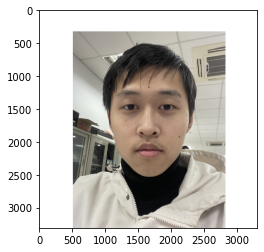

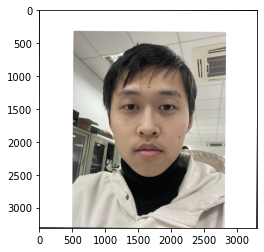

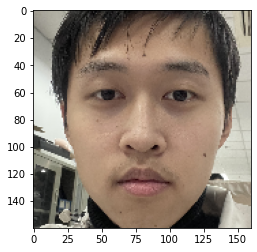

已读取图片: wjz_4.jpg
图中检测到 1 张人脸
{'box': [1534, 1466, 1262, 1663], 'confidence': 0.999997615814209, 'keypoints': {'left_eye': (1878, 2131), 'right_eye': (2448, 2083), 'nose': (2187, 2453), 'mouth_left': (1985, 2777), 'mouth_right': (2439, 2739)}}
正方形人脸位置: x: 502.0, y: 634.5, width: 3326, height: 3326


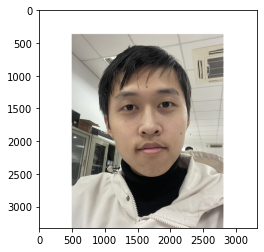

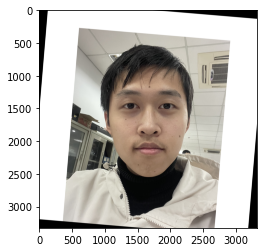

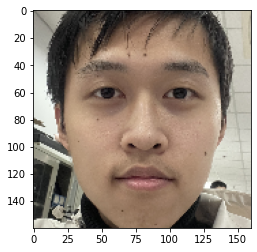

已读取图片: wjz_5.jpg
图中检测到 1 张人脸
{'box': [1647, 2016, 861, 851], 'confidence': 0.9153597950935364, 'keypoints': {'left_eye': (1973, 2429), 'right_eye': (2159, 2209), 'nose': (2168, 2361), 'mouth_left': (2219, 2624), 'mouth_right': (2358, 2449)}}
正方形人脸位置: x: 1216.5, y: 1580.5, width: 1722, height: 1722


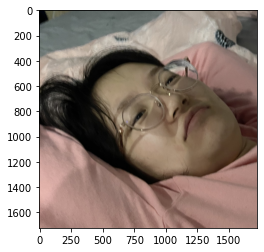

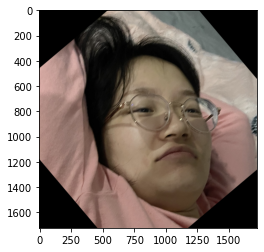

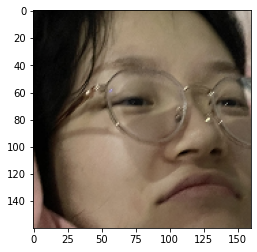

已读取图片: lhy_3.jpg
图中检测到 1 张人脸
{'box': [2721, 2408, 413, 545], 'confidence': 0.9996114373207092, 'keypoints': {'left_eye': (2836, 2620), 'right_eye': (3024, 2620), 'nose': (2929, 2730), 'mouth_left': (2862, 2829), 'mouth_right': (3008, 2832)}}
正方形人脸位置: x: 2382.5, y: 2135.5, width: 1090, height: 1090


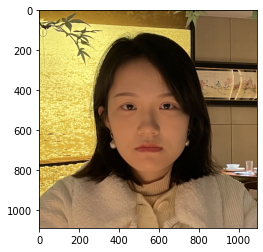

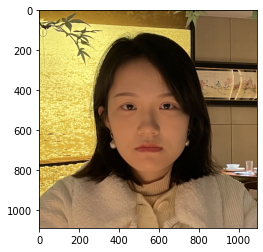

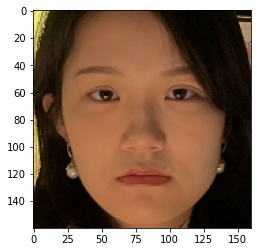

已读取图片: lhy_5.jpg
数据库图像初始化结束
['lhy', 'wjz', 'lhy', 'wjz', 'lhy', 'lhy', 'lhy', 'wjz', 'wjz', 'lhy', 'lhy']
图中检测到 2 张人脸
{'box': [1351, 990, 297, 384], 'confidence': 0.9999004602432251, 'keypoints': {'left_eye': (1436, 1146), 'right_eye': (1566, 1134), 'nose': (1511, 1208), 'mouth_left': (1472, 1292), 'mouth_right': (1564, 1285)}}
正方形人脸位置: x: 1115.5, y: 798.0, width: 768, height: 768


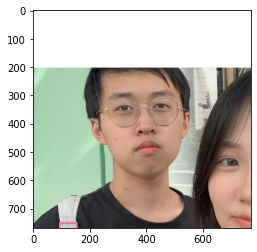

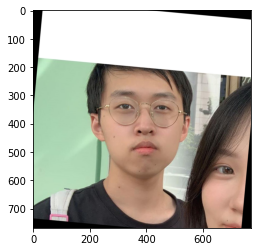

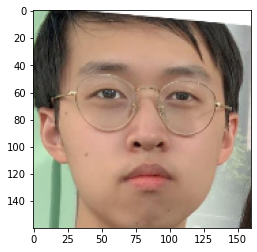

distance: [1.0789462  0.29006168 1.0890538  0.2900956  1.1864418  1.0344837
 1.1516819  0.71665996 0.4224611  0.9516597  1.0209517 ]
result: [False, True, False, True, False, False, False, True, True, False, False]
当前面部识别结果为:  wjz
{'box': [1740, 1119, 392, 555], 'confidence': 0.9983443021774292, 'keypoints': {'left_eye': (1810, 1334), 'right_eye': (1999, 1340), 'nose': (1876, 1453), 'mouth_left': (1817, 1526), 'mouth_right': (1983, 1540)}}
正方形人脸位置: x: 1381.0, y: 841.5, width: 1110, height: 1110


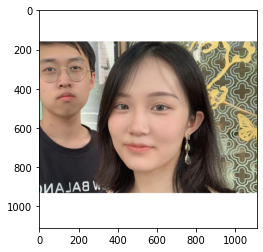

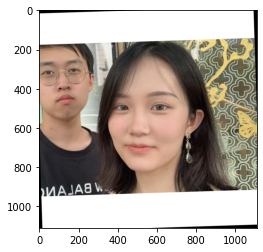

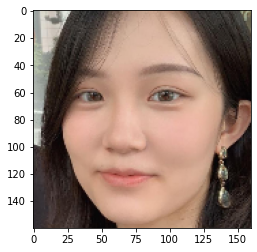

distance: [0.9029241  1.2475499  0.94658    1.2358092  0.6390808  0.68712455
 0.5880003  1.306735   1.2865533  0.8849021  0.8880595 ]
result: [False, False, False, False, True, True, True, False, False, True, True]
当前面部识别结果为:  lhy


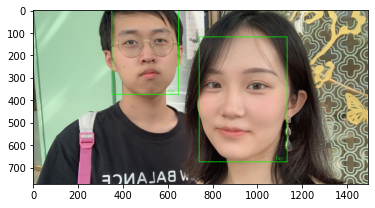

In [ ]:
if __name__ == "__main__":
  # 数据库图像初始化
  # 考虑到数据库中图像都应该是较小且居中的, 故不进行边缘延伸
  facenet_dataset = face_dataset()
  print(facenet_dataset.known_face_names)

  # 读取图片
  filename = "/content/drive/MyDrive/facenet_data/testpic_6.jpg"
  img = imageio.imread(filename)

  # 考虑到各种错综复杂的边界问题, 这里选择将画面边界延伸, 延伸部分均以白色代替
  img = cv2.copyMakeBorder(img, 1000, 1000, 1000, 1000, cv2.BORDER_CONSTANT, value=[255, 255, 255])
  # plt.imshow(img)
  # plt.show()

  # 加载模型
  facenet_model = load_model("/content/drive/MyDrive/facenet_model/facenet_keras.h5")
  
  # 模型输入输出类型
  # print(facenet_model.inputs)
  # print(facenet_model.outputs)

  # 人脸检测
  face_locations = face_detect(img)

  # 边框列表, 逐张添加边框和文字可能会遮挡后识别的面部
  rectangles = []

  # 文字列表
  names = []

  # 人脸逐个显示
  for face_location in face_locations:
    # 人脸位置数据显示
    print(face_location)

    # 获取并显示人脸
    img_face = face_show(img, face_location['box'], face_location['keypoints'])

    # 维度扩展 ()
    img_face = np.expand_dims(img_face, 0)

    # 利用 facenet_model 计算 128 维特征向量
    face_encoding = calc_128_vec(facenet_model, img_face)

    # 与数据库中面部特征进行匹配, 获取票数最高的结果
    face_name = compare_faces(facenet_dataset.known_face_encodings, facenet_dataset.known_face_names, face_encoding, tolerance = 0.9)

    # 显示最终结果
    print("当前面部识别结果为: ", face_name)

    # 边界位置
    x, y, width, height = face_location['box']
      
    # 加入边框列表
    # cv2.rectangle(img, (x, y), (x + width, y + height), (0, 255, 0), 5)
    rectangles.append([x, y, width, height])

    # 加入文字标注列表
    # cv2.putText(img, face_name, (x, y), cv2.FONT_HERSHEY_COMPLEX, 0.5, (0, 255, 0), 0.5)
    names.append(face_name)

  # 边框和名称逐一添加
  for i in range(len(rectangles)):
    # 边框参数
    x, y, width, height = rectangles[i]

    # 添加边框
    cv2.rectangle(img, (x, y), (x + width, y + height), (0, 255, 0), 2)
    
    # 添加文字标注
    cv2.putText(img, names[i], (x + width - 50, y + height - 10), cv2.FONT_HERSHEY_COMPLEX, 0.6, (0, 255, 0), 1)

  # 去掉之前为了提取正方形边框增加的白色图像边界
  height_pic, width_pic, channel = img.shape
  img = img[1000: height_pic - 1000, 1000: width_pic - 1000]

  # 显示最终处理后的图片
  plt.imshow(img)
  
  # plt.show() 会清空 plt 中图片, 保存的图片变为空白, 所以需要先保存, 如果使用别的保存方式, 例如 opencv 就不用放在后面写
  plt.show()

  # 用 opencv 读取图片, 需要调整颜色 RGB 的顺序
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # 保存图片
  cv2.imwrite("test.png", img)

加载下载文件方法

In [ ]:
from google.colab import files

下载图片

In [ ]:
# 下载图片
files.download("test.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>